In [1]:
import requests
import pandas as pd 
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
pd.set_option('display.max_columns', 0)
import random

In [2]:
secrets_file = open("secrets.txt","r")
string = secrets_file.read()
string.split('\n')
secrets_dict={}
for line in string.split('\n'):
    if len(line) > 0:
        secrets_dict[line.split(':')[0]]=line.split(':')[1].strip()

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=secrets_dict['cid'],
                                                           client_secret=secrets_dict['csecret']))

In [3]:
url = "https://www.popvortex.com/music/charts/top-100-songs.php"

#download html with a get request
response = requests.get(url)
response.status_code

#parse html (create the 'soup')
soup = BeautifulSoup(response.content, "html.parser")

In [4]:
#soup

In [5]:
soup.select("#chart-position-1 > div.chart-content.col-xs-12.col-sm-8 > p")

[<p class="title-artist"><cite class="title">Thank God I Do</cite><em class="artist">Lauren Daigle</em></p>]

In [6]:
soup.select("div.chart-content.col-xs-12.col-sm-8 > p > cite")[0].get_text()

'Thank God I Do'

In [7]:
soup.select("div.chart-content.col-xs-12.col-sm-8 > p > em")[0].get_text()

'Lauren Daigle'

In [8]:
title = []
artist = []

num_iter = len(soup.select("div.chart-content.col-xs-12.col-sm-8 > p > cite"))
tlist = soup.select("div.chart-content.col-xs-12.col-sm-8 > p > cite")
alist = soup.select("div.chart-content.col-xs-12.col-sm-8 > p > em")

# iterate through the result set and retrive all the data
for i in range(num_iter):
    title.append(tlist[i].get_text())
    artist.append(alist[i].get_text())

In [9]:
top100 = pd.DataFrame({"title":title, "artist":artist})

In [10]:
top100.head()

,title,artist
0,Thank God I Do,Lauren Daigle
1,Last Night,Morgan Wallen
2,Flowers,Miley Cyrus
3,Fast Car,Luke Combs
4,Calm Down,Rema & Selena Gomez


## Bonus: Get another top 100 song list

In [11]:
url = "https://www.officialcharts.com/charts/singles-chart/"
response = requests.get(url)
response.status_code
soup = BeautifulSoup(response.content, "html.parser")

In [12]:
# soup.select("#main > article > div > div.grid__cell.unit-2-3--desktop > section > table > tbody > tr:nth-child(2) > td:nth-child(3)")

In [13]:
#soup.select("table")[0].find_all("div", {"class":["title", "artist"]})
soup.select("table")[0].find_all("div", class_="artist")[0].get_text()

'\nMILEY CYRUS\n'

In [14]:
song_title = []
artist_name = []

num_iters = len(soup.select("table")[0].find_all("div", class_="title"))
slist = soup.select("table")[0].find_all("div", class_="title")
alist = soup.select("table")[0].find_all("div", class_="artist")

# iterate through the result set and retrive all the data
for i in range(num_iters):
    song_title.append(slist[i].get_text())
    artist_name.append(alist[i].get_text())

In [15]:
top100_two = pd.DataFrame({"title":song_title, "artist":artist_name})
print(top100_two.shape)
top100_two.head()

(100, 2)


,title,artist
0,\nFLOWERS\n,\nMILEY CYRUS\n
1,\nMIRACLE\n,\nCALVIN HARRIS/ELLIE GOULDING\n
2,\nDIE FOR YOU\n,\nWEEKND\n
3,\nCALM DOWN\n,\nREMA\n
4,\nPEOPLE\n,\nLIBIANCA\n


##  PopVortex Song Recommender

In [16]:
def songrecommender():
    song = input("Enter song name: ")
    artist = input("Enter artist name: ")
    
    for i in range(len(top100.values)):
        if (song in top100.values[i][0]) & (artist in top100.values[i][1]):
            recommendation = top100[(top100['title'] != song) & (top100['artist'] != artist)].iloc[random.randint(0,99)]
            return "We recommend: " + recommendation.title + " by " + recommendation.artist 
        
    for i in range(len(top100.values)): 
        if (song not in top100.values[i][0]) & (artist not in top100.values[i][1]):
            return "Sorry, no recommendations available"

In [17]:
songrecommender()

Enter song name: Flowers
Enter artist name: Miley Cyrus


'We recommend: You Proof by Morgan Wallen'

## Add spotify songs

In [18]:
spot_df = pd.read_csv("spotifytracks.csv")

In [19]:
spot_df.head()

,song,artist,uri,features_danceability,features_energy,features_key,features_loudness,features_mode,features_speechiness,features_acousticness,features_instrumentalness,features_liveness,features_valence,features_tempo,features_type,features_id,features_uri,features_track_href,features_analysis_url,features_duration_ms,features_time_signature
0,Run Away,dvsn,spotify:track:0xD824qQkuonQNHe2dSeI4,0.764,0.330,2,-12.801,0,0.0427,0.1000,0.506000,0.1390,0.0686,119.978,audio_features,0xD824qQkuonQNHe2dSeI4,spotify:track:0xD824qQkuonQNHe2dSeI4,https://api.spotify.com/v1/tracks/0xD824qQkuon...,https://api.spotify.com/v1/audio-analysis/0xD8...,140293,4
1,L$D,A$AP Rocky,spotify:track:4S7YHmlWwfwArgd8LfSPud,0.598,0.252,2,-15.086,1,0.0644,0.1940,0.133000,0.0992,0.0352,120.064,audio_features,4S7YHmlWwfwArgd8LfSPud,spotify:track:4S7YHmlWwfwArgd8LfSPud,https://api.spotify.com/v1/tracks/4S7YHmlWwfwA...,https://api.spotify.com/v1/audio-analysis/4S7Y...,238307,4
2,Studio,ScHoolboy Q,spotify:track:29gsi1zZrZxdStACmTQB0Z,0.709,0.589,8,-7.776,0,0.0433,0.0507,0.000000,0.0585,0.5800,133.922,audio_features,29gsi1zZrZxdStACmTQB0Z,spotify:track:29gsi1zZrZxdStACmTQB0Z,https://api.spotify.com/v1/tracks/29gsi1zZrZxd...,https://api.spotify.com/v1/audio-analysis/29gs...,278067,3
3,OTW,Khalid,spotify:track:6Hgh47WXVKtXN5zGOu0hjI,0.652,0.678,2,-6.183,1,0.0541,0.1830,0.000033,0.1060,0.2800,72.989,audio_features,6Hgh47WXVKtXN5zGOu0hjI,spotify:track:6Hgh47WXVKtXN5zGOu0hjI,https://api.spotify.com/v1/tracks/6Hgh47WXVKtX...,https://api.spotify.com/v1/audio-analysis/6Hgh...,263014,4
4,Silence,Marshmello,spotify:track:7vGuf3Y35N4wmASOKLUVVU,0.520,0.761,4,-3.093,1,0.0853,0.2560,0.000005,0.1700,0.2860,141.971,audio_features,7vGuf3Y35N4wmASOKLUVVU,spotify:track:7vGuf3Y35N4wmASOKLUVVU,https://api.spotify.com/v1/tracks/7vGuf3Y35N4w...,https://api.spotify.com/v1/audio-analysis/7vGu...,180823,4


In [20]:
# drop duplicate column
spot_df = spot_df.drop(['features_uri'], axis=1)  

In [21]:
#rename columns
spot_df.columns = spot_df.columns.str.replace(r"features_", "")

In [22]:
#spot_df.head()

In [23]:
#drop categoricals for scaling
justfeat = spot_df.drop(['song','artist','uri','type','id','uri','track_href','analysis_url'], axis=1)

In [24]:
justfeat.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.764,0.330,2,-12.801,0,0.0427,0.1000,0.506000,0.1390,0.0686,119.978,140293,4
1,0.598,0.252,2,-15.086,1,0.0644,0.1940,0.133000,0.0992,0.0352,120.064,238307,4
2,0.709,0.589,8,-7.776,0,0.0433,0.0507,0.000000,0.0585,0.5800,133.922,278067,3
3,0.652,0.678,2,-6.183,1,0.0541,0.1830,0.000033,0.1060,0.2800,72.989,263014,4
4,0.520,0.761,4,-3.093,1,0.0853,0.2560,0.000005,0.1700,0.2860,141.971,180823,4


#### Scale features

In [25]:
from sklearn.preprocessing import StandardScaler

transformer = StandardScaler().fit(justfeat)
featscale = transformer.transform(justfeat)
audfeat = pd.DataFrame(featscale,columns=justfeat.columns)

In [26]:
audfeat.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.562287,-1.870631,-0.918793,-2.247831,-0.969984,-0.992163,-0.635666,5.981899,-0.266094,-1.894764,0.041006,-1.316379,0.050052
1,-0.689334,-2.394570,-0.918793,-3.164146,1.030945,-0.829159,-0.224384,1.458972,-0.569256,-2.053031,0.043899,0.475985,0.050052
2,0.147593,-0.130886,0.760848,-0.232740,-0.969984,-0.987656,-0.851370,-0.153761,-0.879272,0.528527,0.510048,1.203069,-2.802340
3,-0.282180,0.466941,-0.918793,0.406074,1.030945,-0.906530,-0.272513,-0.153366,-0.517459,-0.893036,-1.539589,0.927798,0.050052
4,-1.277445,1.024465,-0.358913,1.645204,1.030945,-0.672165,0.046887,-0.153701,-0.029964,-0.864605,0.780796,-0.575214,0.050052


#### Get optimal K

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

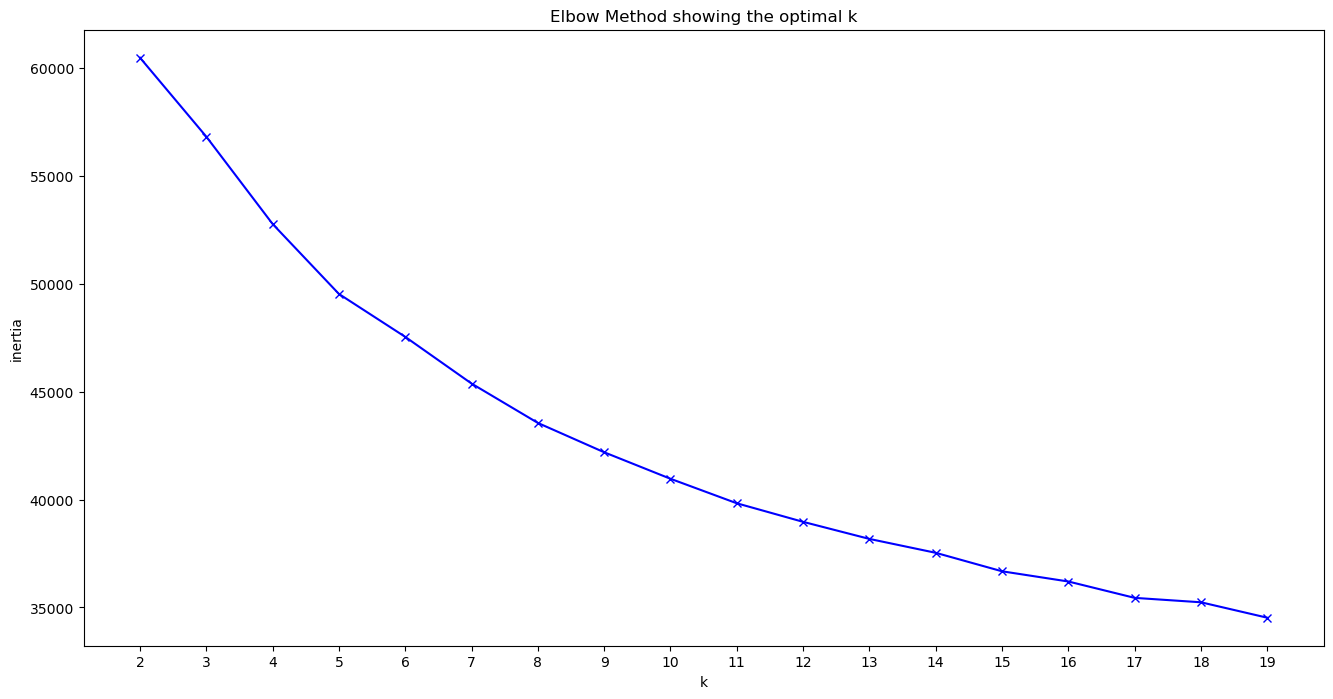

In [27]:
import numpy as np
from sklearn.cluster import KMeans
K = range(2, 20)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(audfeat)
    inertia.append(kmeans.inertia_)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

Text(0.5, 1.0, 'Slhouette score showing the optimal k')

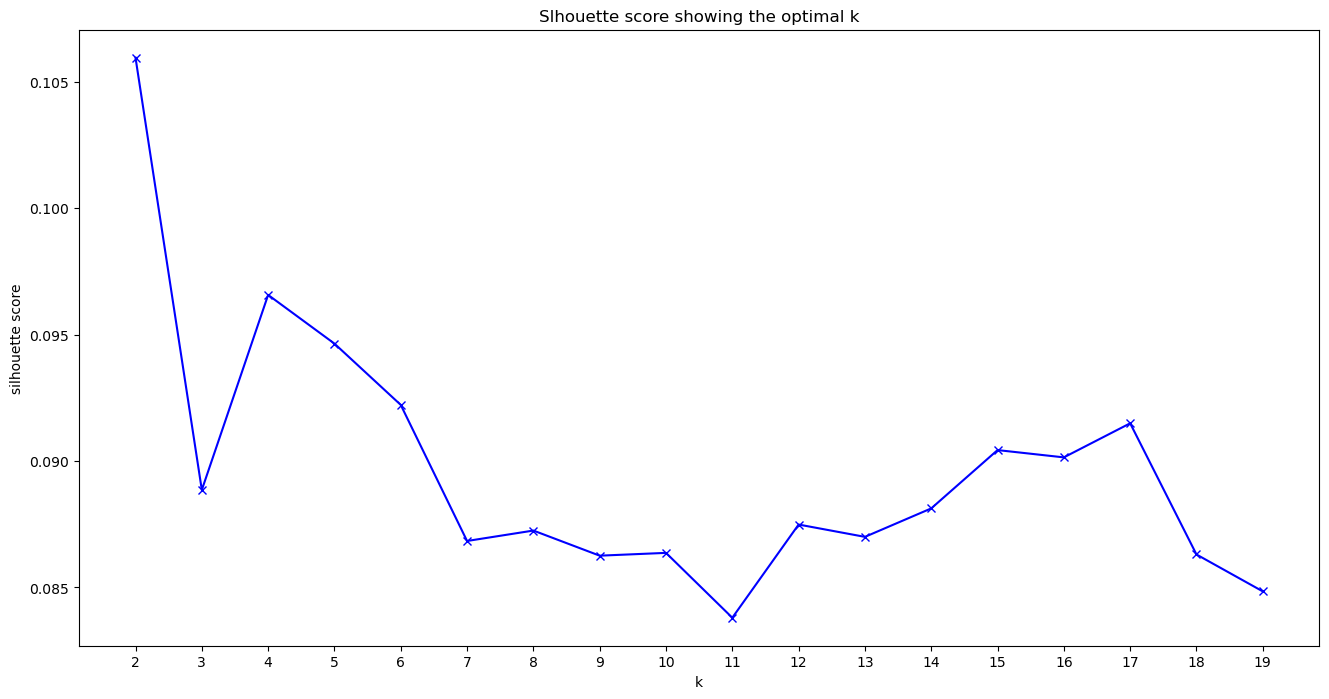

In [28]:
from sklearn.metrics import silhouette_score
K = range(2, 20)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(audfeat)
    silhouette.append(silhouette_score(audfeat, kmeans.predict(audfeat)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Slhouette score showing the optimal k')

#### Use optimal K to make clusters

In [29]:
kmeans = cluster.KMeans(n_clusters=17)
kmeans.fit(audfeat)
pred = kmeans.predict(audfeat)
pred

array([7, 6, 9, ..., 0, 4, 4], dtype=int32)

In [30]:
pd.Series(pred).value_counts().sort_index()

0     419
1     284
2     273
3     486
4     400
5     384
6     241
7      74
8     320
9     136
10     34
11    234
12    546
13    125
14    533
15    416
16    281
dtype: int64

#### Add cluster numbers to dataframe

In [31]:
spot_df['clusters'] = pred

In [32]:
spot_df.head()

,song,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,track_href,analysis_url,duration_ms,time_signature,clusters
0,Run Away,dvsn,spotify:track:0xD824qQkuonQNHe2dSeI4,0.764,0.330,2,-12.801,0,0.0427,0.1000,0.506000,0.1390,0.0686,119.978,audio_features,0xD824qQkuonQNHe2dSeI4,https://api.spotify.com/v1/tracks/0xD824qQkuon...,https://api.spotify.com/v1/audio-analysis/0xD8...,140293,4,7
1,L$D,A$AP Rocky,spotify:track:4S7YHmlWwfwArgd8LfSPud,0.598,0.252,2,-15.086,1,0.0644,0.1940,0.133000,0.0992,0.0352,120.064,audio_features,4S7YHmlWwfwArgd8LfSPud,https://api.spotify.com/v1/tracks/4S7YHmlWwfwA...,https://api.spotify.com/v1/audio-analysis/4S7Y...,238307,4,6
2,Studio,ScHoolboy Q,spotify:track:29gsi1zZrZxdStACmTQB0Z,0.709,0.589,8,-7.776,0,0.0433,0.0507,0.000000,0.0585,0.5800,133.922,audio_features,29gsi1zZrZxdStACmTQB0Z,https://api.spotify.com/v1/tracks/29gsi1zZrZxd...,https://api.spotify.com/v1/audio-analysis/29gs...,278067,3,9
3,OTW,Khalid,spotify:track:6Hgh47WXVKtXN5zGOu0hjI,0.652,0.678,2,-6.183,1,0.0541,0.1830,0.000033,0.1060,0.2800,72.989,audio_features,6Hgh47WXVKtXN5zGOu0hjI,https://api.spotify.com/v1/tracks/6Hgh47WXVKtX...,https://api.spotify.com/v1/audio-analysis/6Hgh...,263014,4,3
4,Silence,Marshmello,spotify:track:7vGuf3Y35N4wmASOKLUVVU,0.520,0.761,4,-3.093,1,0.0853,0.2560,0.000005,0.1700,0.2860,141.971,audio_features,7vGuf3Y35N4wmASOKLUVVU,https://api.spotify.com/v1/tracks/7vGuf3Y35N4w...,https://api.spotify.com/v1/audio-analysis/7vGu...,180823,4,16


## Song Recommeder for GNOD

In [33]:
def songrecommender():
    song = input("Enter song name: ")
    artist = input("Enter artist name: ")
    
    #songs in top100 playlist
    for i in range(len(top100.values)):
        if (song in top100.values[i][0]) & (artist in top100.values[i][1]):
            recommendation = top100[(top100['title'] != song) & (top100['artist'] != artist)].iloc[random.randint(0,99)]
            return "We recommend: " + recommendation.title + " by " + recommendation.artist 
    
    #songs in spotify playlist
    for i in range(len(spot_df.values)): 
            if (song in spot_df.values[i][0]) & (artist in spot_df.values[i][1]):
                clusternum = spot_df.values[i][20]
                cluster = spot_df[spot_df['clusters'] == clusternum]
                recommendation = cluster[(cluster['song'] != song) & (cluster['artist'] != artist)].iloc[random.randint(0,len(cluster))]
                return "We recommend: " + recommendation.song + " by " + recommendation.artist 
    
    #songs not in any playlist
    for i in range(len(spot_df.values)): 
            if (song not in spot_df.values[i][0]) & (artist not in spot_df.values[i][1]):
                track_id = sp.search(q='artist:' + artist + ' track:' + song, type='track')
                songuri = track_id["tracks"]["items"][0]["uri"] 
                sp.audio_features(songuri)
                
                track_id = sp.search(q='artist:' + artist + ' track:' + song, type='track')
                uritest = track_id["tracks"]["items"][0]["uri"]
                get_feat = sp.audio_features(uritest)
                featdf = pd.DataFrame(get_feat)
                featdf = featdf.drop(['type','id','uri','track_href','analysis_url'], axis=1)
                featnorm = transformer.transform(featdf)
                featnorm = pd.DataFrame(featnorm,columns=featdf.columns)
                clustnum = kmeans.predict(featnorm)[0]
                
                cluster = spot_df[spot_df['clusters'] == clustnum]
                recommendation = cluster[(cluster['song'] != song) & (cluster['artist'] != artist)].iloc[random.randint(0,len(cluster))]
                return "We recommend: " + recommendation.song + " by " + recommendation.artist 
                        

#### Test with a song from the Hot100 playlist

In [37]:
songrecommender()

Enter song name: Fast Car
Enter artist name: Luke Combs


'We recommend: Eyes Closed by Ed Sheeran'

#### Test with a song from spotify playlist

In [38]:
songrecommender()

Enter song name: Silence
Enter artist name: Marshmello


'We recommend: Candy Paint by Post Malone'

#### Test with a random song not in any of the playlists

In [39]:
songrecommender()

Enter song name: High
Enter artist name: Adekunle Gold


'We recommend: Rock That Body by Black Eyed Peas'